In [10]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics
import trace_classification

# Data Preparation


Prepare the data to be used with kNN

In [11]:
plots = [#("traces/normal/", 'grid_normal_2019-02-19_21'),
         ("traces/1bh-7/", 'grid_1bh-7_2019-02-19_22'),
         ("traces/1bh-9/", 'grid_1bh-9_2019-02-20_00'),
         ("traces/1gh30-7/", 'grid_1gh30-7_2019-02-19_22'),
         ("traces/1gh30-9/", 'grid_1gh30-9_2019-02-20_00'),
         ("traces/1gh50-7/", 'grid_1gh50-7_2019-02-19_22'),
         ("traces/1gh50-9/", 'grid_1gh50-9_2019-02-19_23'),
         ("traces/1gh70-7/", 'grid_1gh70-7_2019-02-19_23'),
         ("traces/1gh70-9/", 'grid_1gh70-9_2019-02-19_23')
        ]

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    experiment = row[0].split('/')[1]
    
    # Assign a label
    if row[0].find('gh') >= 0:
        label = 'GH'
    else:
        label = 'BH'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,label
0,aaaa::212:740e:e:e0e:,1bh-7,184,612.706522,125194.722143,353.828662,5,246.0,3156.0,0.080,BH
1,aaaa::212:7406:6:606:,1bh-7,166,346.132530,64980.721723,254.913165,3,137.0,2237.0,0.170,BH
2,aaaa::212:7411:11:1111:,1bh-7,139,666.827338,185825.506204,431.074827,5,262.0,3312.0,0.305,BH
3,aaaa::212:7407:7:707:,1bh-7,154,299.876623,33707.546770,183.596151,2,118.0,1153.0,0.230,BH
4,aaaa::212:740d:d:d0d:,1bh-7,152,474.940789,68912.691835,262.512270,4,234.0,1746.0,0.240,BH


# Feature Selection

Select the set of features and labels that we use to fit the algorithm

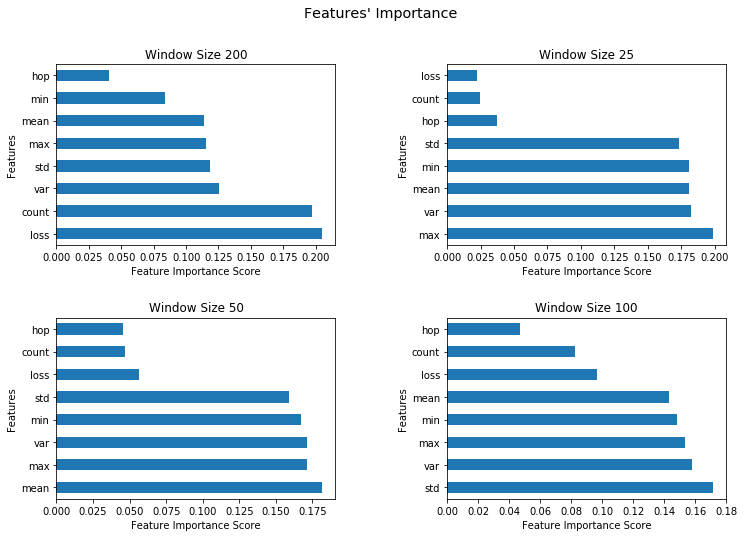

In [12]:
plots_analysis.random_forests_features_selection(trace_stats)

In [13]:
results = None            # Results from each classification algorithm
cv_results = None         # Cross validation results from each classification algorithm

features_to_drop = ['node_id', 'experiment', 'label', 'hop', 'loss', 'count']

# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

In [14]:
results = pd.concat([results, 
                     trace_classification.random_forest_classification(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [15]:
cv_results = pd.concat([cv_results, 
                     trace_classification.random_forest_cross_validation(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

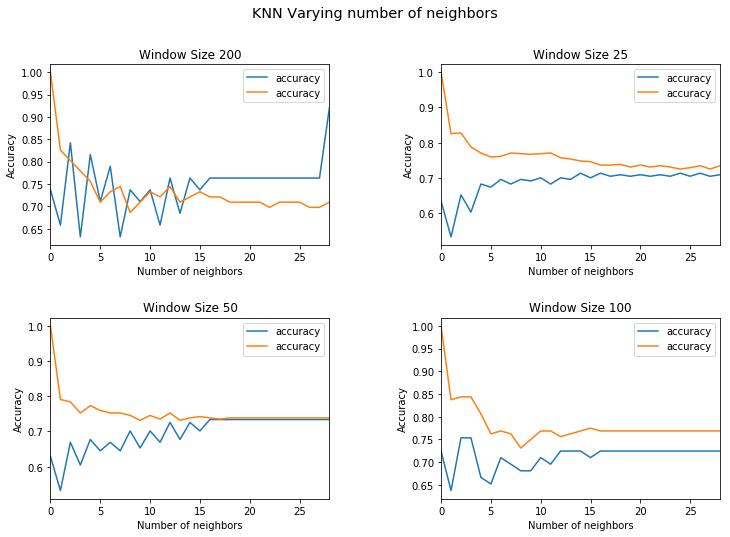

In [16]:
plots_analysis.knn_test_number_of_neighbors(trace_stats, 30)

Let's build KNN classifier 

In [17]:
results = pd.concat([results, 
                     trace_classification.k_nearest_neighbor_classification(trace_stats, features_to_drop, n_neighbors=30)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 

We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [18]:
cv_results = pd.concat([cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(trace_stats, features_to_drop, n_neighbors=30)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [19]:
results = pd.concat([results, 
                     trace_classification.support_vector_machines_classification(trace_stats, features_to_drop, kernel='linear')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [20]:
cv_results = pd.concat([cv_results, 
                     trace_classification.support_vector_machines_cross_validation(trace_stats, features_to_drop, kernel='linear')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Results

Results from each model

In [23]:
results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Time (ms)
0,Random Forest,200,0.631579,0.461538,0.333333,0.387097,0.090629
1,Random Forest,25,0.656388,0.507162,0.504505,0.492490,0.116929
2,Random Forest,50,0.709677,0.553500,0.522145,0.502674,0.145753
3,Random Forest,100,0.753623,0.714286,0.585263,0.584779,0.087030
4,KNN,200,0.763158,0.467742,0.402778,0.432836,0.010355
5,KNN,25,0.713656,0.526042,0.501678,0.430946,0.014241
6,KNN,50,0.733871,0.366935,0.500000,0.423256,0.013369
7,KNN,100,0.724638,0.362319,0.500000,0.420168,0.006088
8,SVM,200,0.684211,0.464286,0.361111,0.406250,29.217087
9,SVM,25,0.638767,0.502317,0.501725,0.495391,84.119497


Here we plot the average results for each model computed with cross validation

In [24]:
cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.677487
1,Random Forest,25,0.672924
2,Random Forest,50,0.644742
3,Random Forest,100,0.650091
4,KNN,200,0.774513
5,KNN,25,0.725853
6,KNN,50,0.732381
7,KNN,100,0.746811
8,SVM,200,0.710513
9,SVM,25,0.680959
